This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict if the movie is profitable given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

We use XGBoost Classifier to predict if a movie is profitable.

XGBoost Classifier optimized over hyperparameter values can predict if a movie is profitable with 83% accuracy. This is very similar to the accuracy of the Random Forest Classifier.

In [2]:
# Basic libraries required
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
# xgboost for performing classification

from sklearn.model_selection import train_test_split,GridSearchCV 
# Gridsearchcv for hyperparameter tuning
# train_test_split for splitting

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
#these are classification evaluation metric

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the Movie Dataset from the Harvard Edx website.



In [3]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


We can look at the shape of the data set:

In [4]:
df.shape

(4803, 22)

We replace infinite values with NaN values in the data frame. NaN values are handled later.

In [5]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column.

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.



In [6]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

We create a new column indicating if a movie is profitable.

The 'profitable' column is the difference between 'revenue' and 'budget' column.



In [7]:
df['profitable'] = df['revenue']
for i in range(len(df['revenue'])):
    if df['revenue'].iloc[i] >= df['budget'].iloc[i]:
        df['profitable'].iloc[i] = 1
    else:
        df['profitable'].iloc[i] = 0

In [8]:
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,Drama,Foreign,Comedy,History,War,TV Movie,Action,Fantasy,Documentary,profitable
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,0,0,0,1,1,0,1
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,0,0,0,1,1,0,1
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,1,0,0,1
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1,0,0,0,0,0,1,0,0,1
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,0,0,0,0,0,0,1,0,0,1
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,0,1,0,0,0,0,0,0,0
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,1,0,1,0,0,1,0,0,0,1
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,0,0,0,0,0,0,0,0,1


Descriptive Statistics.

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data.

Then we get the information about missing values in the data

In [9]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

Column Statistics:

In [10]:
# Summary statistic of the data
df.describe() 

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,Western,Music,...,Drama,Foreign,Comedy,History,War,TV Movie,Action,Fantasy,Documentary,profitable
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,7.703691e+02,7.703906e+02,...,7.708303e+02,7.703592e+02,7.707106e+02,7.703931e+02,7.703821e+02,7.703537e+02,7.705923e+02,7.704403e+02,7.703750e+02,0.723923
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,3.441409e+04,3.441409e+04,...,3.441408e+04,3.441409e+04,3.441408e+04,3.441409e+04,3.441409e+04,3.441409e+04,3.441408e+04,3.441409e+04,3.441409e+04,0.447102
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.000000


Find which rows contain NaN values.

In [11]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
Western                    0
Music                      0
Adventure                  0
Animation                  0
Mystery                    0
Science Fiction            0
Crime                      0
Romance                    0
Family                     0
Thriller                   0
Horror                     0
Drama                      0
Foreign       

Conclusions:

The data contains some categorical columns, these columns need to be handled before building the model.

Some columns have missing values, these need to be handled before building the model. Since the columns with missing values are categorical, we are not going to have a problem with dropping the missing values.

The y variable (profitable) doesn't have any missing values, which is good.

Now we list the numeric and categorical columns.

In [12]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'Western', 'Music', 'Adventure', 'Animation',
       'Mystery', 'Science Fiction', 'Crime', 'Romance', 'Family', 'Thriller',
       'Horror', 'Drama', 'Foreign', 'Comedy', 'History', 'War', 'TV Movie',
       'Action', 'Fantasy', 'Documentary', 'profitable'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'profitable' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data and we are going to drop the 'cast' column.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In addition we are going to drop the 'revenue' column, because it is linearly dependent on the related 'profitable' column we are going to predict.

We are going to drop the columns 'id' and 'movie_id', because they carry no information.

In [13]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast', 'revenue', 'id', 'movie_id'])
df = df.dropna()
print(df.shape)

(4801, 26)


As a result of dropping categorical columns and the revenue column, only two rows remained with NaN values, when they were droppped the data frame has 4801 rows left.

In [14]:
df.head()

,budget,popularity,runtime,vote_average,vote_count,Western,Music,Adventure,Animation,Mystery,...,Drama,Foreign,Comedy,History,War,TV Movie,Action,Fantasy,Documentary,profitable
0,237000000,150.437577,162.0,7.2,11800,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,1
1,300000000,139.082615,169.0,6.9,4500,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,1
2,245000000,107.376788,148.0,6.3,4466,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,250000000,112.312950,165.0,7.6,9106,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
4,260000000,43.926995,132.0,6.1,2124,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


The histograms of the columns.

First we determine the distribution of the target variable 'profitable'.

The value counts for the profitable column are:
1    3477
0    1324
Name: profitable, dtype: int64


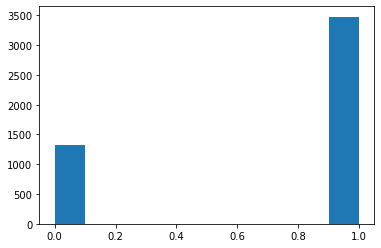

In [15]:
# 'profitable' is the target column y.
print('The value counts for the profitable column are:')
print(df.profitable.value_counts())
plt.hist(df['profitable'])
plt.show()

To check the distribution of variables, we plot the histograms to check variable distributions to find out if they are normal or skewed.

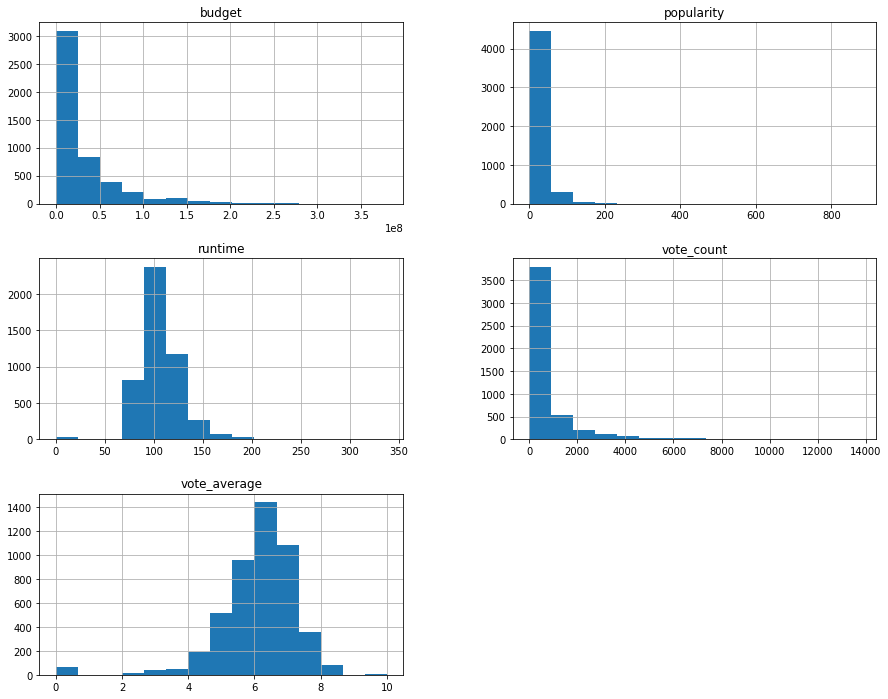

In [16]:
# plot histograms of the variables
params = df[['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']]

params.hist(figsize=(15,12),bins = 15)

plt.show()

We see that the distributions of 'budget', 'popularity', 'runtime' and 'vote_count' are right skewed.

We can plot a heat map showing the correlations between 'budget', 'popularity', 'runtime', 'vote_average', 'vote_count' and 'profitable' columns.

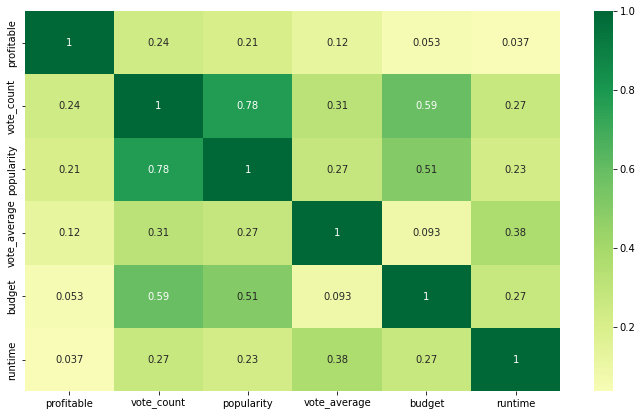

In [17]:
main_columns = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'profitable']
k = 6 #number of variables for heatmap
cols = df.corr().nlargest(k, 'profitable')['profitable'].index
plt.figure(figsize=(12,7))
p = sns.heatmap(df[cols].corr(), annot=True,cmap='RdYlGn',center=0) 
#correlation plot

Model building.

We take X to be all columns except for the 'profitable' column.  Let the target variable y be the 'profitable' column.

In [18]:
X=df.drop("profitable",axis=1)
y=df["profitable"]

#get feature and target variable

Train test split

We split both X and y into the test data and the training data.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=420)
#get training and testing data

Parameters for Tree Booster (from XGBoost website)

eta [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]

gamma [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]

max_depth [default=6]
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.
range: [0,∞]

min_child_weight [default=1]
Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
range: [0,∞]

max_delta_step [default=0]
Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
range: [0,∞]

subsample [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

lambda [default=1, alias: reg_lambda]
L2 regularization term on weights. Increasing this value will make model more conservative.

alpha [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.



Model Building

First we try XGBoost with the default parameter values.

In [19]:
xgb_cls = xgb.XGBClassifier()

#initialize the xgb classifier 
xgb_cls.fit(x_train, y_train)

y_pred = xgb_cls.predict(x_test)

In [25]:
# evaluation metric

print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Classification report--------
               precision    recall  f1-score   support

           0       0.68      0.60      0.64       421
           1       0.86      0.90      0.88      1164

    accuracy                           0.82      1585
   macro avg       0.77      0.75      0.76      1585
weighted avg       0.81      0.82      0.82      1585

--------Confusion Matrix--------
 [[ 254  167]
 [ 120 1044]]
Accuracy Score : 0.82
f1 score : 0.879158


It turns out, that the default parameters give a fairly good accuracy.

Now we try to change the learning_rate.

Learninig rate is set low to prevent overfitting. 

Let's take it as 0.0001 and check the scores.

In [32]:
xgb_cls = xgb.XGBClassifier(learning_rate = 0.0001, n_estimators = 500)

xgb_cls.fit(x_train, y_train)


y_pred = xgb_cls.predict(x_test)


print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test  accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Classification report--------
               precision    recall  f1-score   support

           0       0.65      0.66      0.65       421
           1       0.88      0.87      0.87      1164

    accuracy                           0.81      1585
   macro avg       0.76      0.77      0.76      1585
weighted avg       0.82      0.81      0.82      1585

--------Confusion Matrix--------
 [[ 278  143]
 [ 151 1013]]
Test  accuracy Score : 0.81
f1 score : 0.873276


We conclude that low learning rate does not increase the accuracy.


No we try to increase the min_child_weight, the learning rate and increase the number of trees used.

Let's take min_child_weight as 10, where min_child_weight is the minimum sum of instances for the child tree.

In [22]:
xgb_cls = xgb.XGBClassifier(min_child_weight=10, learning_rate = 0.01, n_estimators = 1000)

xgb_cls.fit(x_train, y_train)


y_pred = xgb_cls.predict(x_test)


print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test  accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Confusion Matrix--------
 [[ 254  167]
 [ 120 1044]]
Test  accuracy Score : 0.82
f1 score : 0.879158


We got the same accuracy as with the default parameter values.

Hyperparameter Tuning

To find the best parameters for XGBoost algorithm, we need to do a grid search. 

The main problem is the amount of time it takes.

For that reason, we keep the number of estimators low.

In [23]:
from sklearn.model_selection import GridSearchCV
#import grid searchcv for hypeparameter tuning

xgb_clf = xgb.XGBClassifier(objective=  'binary:logistic' ,learning_rate=0.1) #objective = logistic for binary classification
params = {
        'n_estimators': [100, 500],
        'max_depth': [3, 5, 7, 9, 15, 30],
        'min_child_weight':[2,5,10, 15],
        'gamma':[0,0.03,0.1,0.3],
        'reg_alpha':[1e-5, 1e-2,  0.5, 0.75, 0.9],
        'reg_lambda':[1e-5, 1e-2, 0.45],
        }
#define params 


grid_search = GridSearchCV(xgb_clf, params, n_jobs=-1, cv = 3, verbose=1)

grid_search.fit(x_train, y_train)
#fit the params

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [24]:
#let's see the best parameters as per our grid search
grid_search.best_params_

{'gamma': 0.3,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'reg_alpha': 0.01,
 'reg_lambda': 0.45}

In [27]:
y_pred = grid_search.predict(x_test)

print('After hyperparametertuning\n')
print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test Accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

After hyperparametertuning

--------Classification report--------
               precision    recall  f1-score   support

           0       0.70      0.63      0.66       421
           1       0.87      0.90      0.89      1164

    accuracy                           0.83      1585
   macro avg       0.79      0.77      0.78      1585
weighted avg       0.83      0.83      0.83      1585

--------Confusion Matrix--------
 [[ 264  157]
 [ 111 1053]]
Test Accuracy Score : 0.83
f1 score : 0.887110


We now try all the optimal parameters with a higher number of trees.

In [30]:
xgb_cls = xgb.XGBClassifier(gamma = 0.3,
 max_depth = 3, subsample = 1, 
 min_child_weight = 5,
 n_estimators = 5000,
 reg_alpha = 0.01,
 reg_lambda = 0.45,
 random_state = 420)

#initialize the xgb classifier 
xgb_cls.fit(x_train, y_train)

y_pred = xgb_cls.predict(x_test)

In [31]:
print('--------Classification report--------\n',classification_report(y_test, y_pred))
print('--------Confusion Matrix--------\n',confusion_matrix(y_test, y_pred))
print('Test  accuracy Score : %.2f'%accuracy_score(y_test, y_pred))
print('f1 score : %2f'%f1_score(y_test, y_pred))

--------Classification report--------
               precision    recall  f1-score   support

           0       0.66      0.61      0.63       421
           1       0.86      0.88      0.87      1164

    accuracy                           0.81      1585
   macro avg       0.76      0.75      0.75      1585
weighted avg       0.81      0.81      0.81      1585

--------Confusion Matrix--------
 [[ 258  163]
 [ 134 1030]]
Test  accuracy Score : 0.81
f1 score : 0.873992


We conclude that increasing the number of trees in XGBoost does not improve the accuracy of the prediction.

For comparison, we run the Random Forest Classifier with a large number of trees.

In [27]:
# Importing the library
from sklearn.ensemble import RandomForestClassifier

#storing the random forest classifier into clftree
clftree = RandomForestClassifier(random_state=42, n_estimators = 25000, max_depth=15, criterion='entropy',
                                max_features = 'auto')
clftree.fit(x_train, y_train)
clftree.score(x_test,y_test)

0.8214511041009463

XGBoost Classifier achieves the accuracy of 83% which is about 6% more accurate than the Decision Tree Classfier.
XGBoost Classifier achieves close to optimal accuracy with the default parameter values. However it is difficult to fine tune to improve its accuracy. Increasing the number of trees used does not improve the accuracy of XGBoost Classifier.